In [1]:
#https://www.kaggle.com/competitions/cse7512-00-dl-tp-pt1

#CIFAR-10 datset

import tensorflow as tf
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score, plot_confusion_matrix

import missingno as msno
import plotly_express as px
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras import datasets, layers, models




#defining dataset
(X,y), (x_test, y_test) =datasets.cifar10.load_data()
assert X.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y.shape == (50000, 1)
assert y_test.shape == (10000, 1)


#convert y to categorical
Y = to_categorical(y)
#shuffler
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


X,Y=unison_shuffled_copies(X, Y)

#split X,Y into four parts
p=len(X)/4
X1=X[:int(p)]
X2=X[int(p):int(2*p)]
X3=X[int(2*p):int(3*p)]
X4=X[int(3*p):]
Y1=Y[:int(p)]
Y2=Y[int(p):int(2*p)]
Y3=Y[int(2*p):int(3*p)]
Y4=Y[int(3*p):]


epochy=100

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 96, 96, 3)         0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 20)                40980 

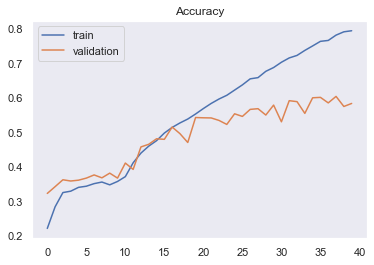

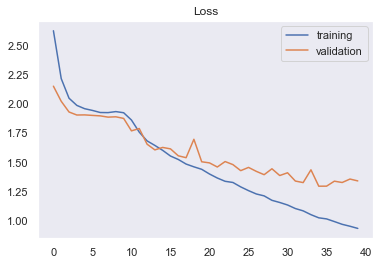

In [2]:
#Train the shadow network using the shadow in set

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,Rescaling, MultiHeadAttention,BatchNormalization, Reshape
from tensorflow.keras import activations
from keras.regularizers import l2


input_shape=X.shape[1:]
output_shape=Y.shape[1]
num_classes=Y.shape[1]

# transfer learning strategy----------------------------------------------------------
shadow_base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False)

shadow_base_model.trainable = False
shadow_base_model.layers.pop()

inputs = keras.Input(shape=(32,32,3))
#resizing layer
x=layers.experimental.preprocessing.Resizing(96, 96, interpolation="bilinear")(inputs)
x = shadow_base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x=Dense(20,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Activation('relu')(x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(num_classes)(x)
outputs=Activation('softmax')(x)
shadow_model = keras.Model(inputs, outputs)

shadow_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
shadow_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="categorical_crossentropy",metrics=['accuracy'])
shadow_model.summary()

shadow_history = shadow_model.fit(
    X1, Y1, batch_size=32, epochs=10,validation_split=0.2,verbose=0,callbacks=[callback]
)
acc1 = shadow_history.history['accuracy']
val_acc1 = shadow_history.history['val_accuracy']
loss1 = shadow_history.history['loss']
val_loss1 = shadow_history.history['val_loss']

#-----------------

shadow_base_model.trainable = True

shadow_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
shadow_history = shadow_model.fit(
    X1, Y1, batch_size=32, epochs=30,validation_split=0.2,verbose=0,callbacks=[callback]
)


acc2 = shadow_history.history['accuracy']
val_acc2=shadow_history.history['val_accuracy']
loss2 = shadow_history.history['loss']
val_loss2=shadow_history.history['val_loss']
#---------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Apply the default theme
sns.set_theme()

plt.figure()
acc = acc1+acc2
val_acc = val_acc1+val_acc2
loss = loss1+loss2
val_loss = val_loss1+val_loss2

epochs = range(len(acc))

plt.plot(epochs, acc,label='train')
plt.plot(epochs, val_acc,label='validation')
plt.title('Accuracy')
plt.legend()
plt.grid()

plt.figure()

plt.plot(epochs, loss,label='training')
plt.plot(epochs, val_loss,label='validation')
plt.title('Loss')
plt.grid()
plt.legend()



391/391 [==============================] - 8s 22ms/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 100, 1)      2           ['input_3[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 100, 1)      28673       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                    

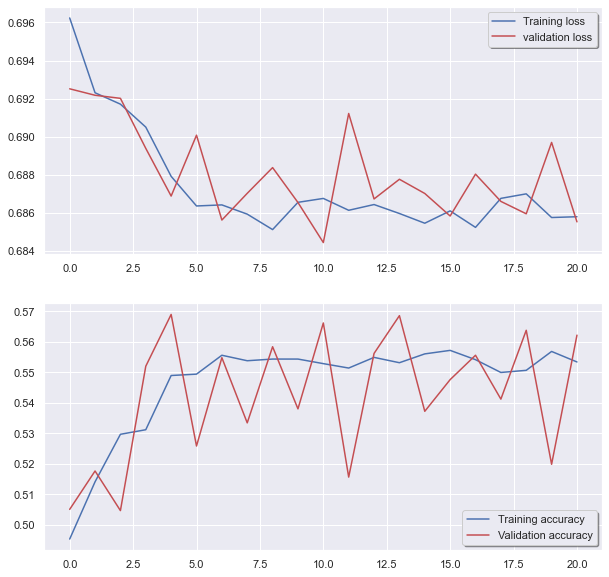

In [3]:
#Train the attack network using the outputs of the shadow in and shadow out set when sent through the shadow network.
#X1,Y1--->shadow in
#X2,Y2--->shadow out
# I see that whole success of this attack is reliant on generalizability of attack network,
#  since current training is independent of testing of target model
import tensorflow_addons as tfa
shadow_Y1=shadow_model.predict(X1)
shadow_Y2=shadow_model.predict(X2)
bin_Y1=np.ones((len(shadow_Y1),1))
bin_Y2=np.zeros((len(shadow_Y2),1))
#vstack shadow_Y1 and shadow_Y2
shadow_Y=np.vstack((shadow_Y1,shadow_Y2))
#vstack bin_Y1 and bin_Y2
bin_Y=np.vstack((bin_Y1,bin_Y2))

#shuffle shadow_Y and bin_Y
shadow_Y,bin_Y=unison_shuffled_copies(shadow_Y, bin_Y)
shadow_Y=np.expand_dims(shadow_Y, axis=-1)

#spline interpolation
dil_fact=10
omega=1
A=0.1
from scipy import interpolate
shadow_Y_inter=np.zeros((shadow_Y.shape[0],shadow_Y.shape[1]*dil_fact,shadow_Y.shape[2]))
for i in range(shadow_Y.shape[0]):
    for j in range(shadow_Y.shape[2]):
        signal=shadow_Y[i,:,j]
        time=np.linspace(0, len(signal), num=len(signal), endpoint=True)
        time_new = np.linspace(0, len(signal), num=dil_fact*len(signal), endpoint=True)
        f = interpolate.interp1d(time, signal, kind='cubic')
        sn=f(time_new)
        shadow_Y_inter[i,:,j]=sn+A*np.cos(omega*2*np.pi*sn/np.max(sn))
        # shadow_Y_inter[i,:,j]=sn



#---------------------------------------------------------------------------------

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


input_shape = shadow_Y_inter.shape[1:]
attack_model = build_model(
    input_shape,
    head_size=256,
    num_heads=16,
    ff_dim=16,
    num_transformer_blocks=1,
    mlp_units=[10],
    mlp_dropout=0.2,
    dropout=0.1,
)

#---------------------------------------------------------------------------------
EPOCHS=epochy
LEARNING_RATE=1e-3
BATCH_SIZE=4
WEIGHT_DECAY=1e-4

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(X3) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
attack_model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY),loss="binary_crossentropy",metrics=['acc'])
attack_model.summary()
history_attack = attack_model.fit(
    shadow_Y_inter, bin_Y, batch_size=4, epochs=epochy,validation_split=0.2,callbacks=[callback],verbose=0
)

#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].plot(history_attack.history['loss'], color='b', label="Training loss")
ax[0].plot(history_attack.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_attack.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_attack.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

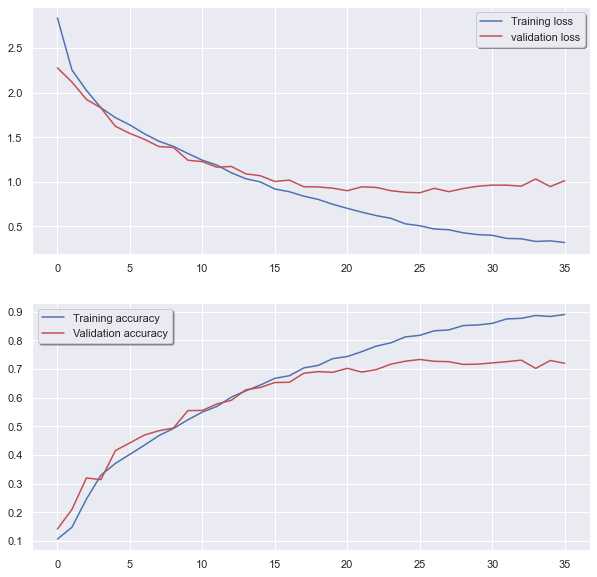

In [4]:
#Train the target network using the target in set
#X3,Y3--->target in
import tensorflow_addons as tfa
input_shape=X.shape[1:]
output_shape=Y.shape[1]
#---------------------------------------------------------------------------------
# a 3-block vgg style architecture
target_model = Sequential()
#add rescaling layer
target_model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
target_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
target_model.add(Dropout(0.2))
target_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
target_model.add(Dropout(0.3))
target_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
target_model.add(Dropout(0.4))
target_model.add(Flatten())
target_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform',name="getter"))
target_model.add(Dense(output_shape, activation='softmax'))

#---------------------------------------------------------------------------------

EPOCHS=epochy
LEARNING_RATE=1e-3
BATCH_SIZE=32
WEIGHT_DECAY=1e-4

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(X3) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
target_model.compile(optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY),loss="categorical_crossentropy",metrics=['acc'])
target_model.summary()
history_target = target_model.fit(
    X3, Y3, batch_size=32, epochs=epochy,validation_split=0.2,verbose=0,callbacks=[callback]
)

#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].plot(history_target.history['loss'], color='b', label="Training loss")
ax[0].plot(history_target.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_target.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_target.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

782/782 [==============================] - 5s 6ms/step
-------------------------------------------------------------------
Accuracy: 0.50284
Precision: 0.504420949071912
Recall: 0.20384
F1 score: 0.29078459343794577


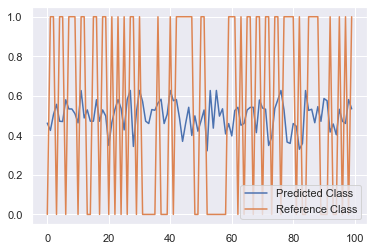

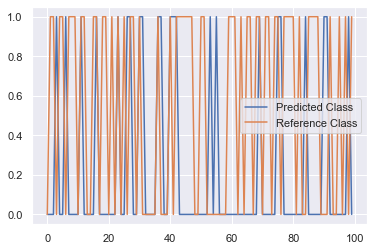

In [5]:
#Test the attack network using the outputs of the target in and target out set when sent through the target network.
#X3,Y3--->target in
#X4,Y4--->target out

target_Y3=target_model.predict(X3)
target_Y4=target_model.predict(X4)
bin_Y3=np.ones((len(target_Y3),1))
bin_Y4=np.zeros((len(target_Y4),1))
#vstack target_Y3 and target_Y4
target_Y=np.vstack((target_Y3,target_Y4))
#vstack bin_Y3 and bin_Y4
bin2_Y=np.vstack((bin_Y3,bin_Y4))

#shuffle target_Y and bin2_Y
target_Y,bin2_Y=unison_shuffled_copies(target_Y, bin2_Y)
target_Y=np.expand_dims(target_Y, axis=-1)

#spline interpolation

omega=1
A=0.1
from scipy import interpolate
target_Y_inter=np.zeros((target_Y.shape[0],target_Y.shape[1]*dil_fact,target_Y.shape[2]))
for i in range(target_Y.shape[0]):
    for j in range(target_Y.shape[2]):
        signal=target_Y[i,:,j]
        time=np.linspace(0, len(signal), num=len(signal), endpoint=True)
        time_new = np.linspace(0, len(signal), num=dil_fact*len(signal), endpoint=True)
        f = interpolate.interp1d(time, signal, kind='cubic')
        sn=f(time_new)
        target_Y_inter[i,:,j]=sn+A*np.sin(omega*2*np.pi*sn/np.max(sn))
        # shadow_Y_inter[i,:,j]=sn

bin2_Y_pred=attack_model.predict(target_Y_inter)

#binarize bin2_Y_pred
bin2_Y_pred_star=np.copy(bin2_Y_pred)
bin2_Y_pred=np.where(bin2_Y_pred>0.55,1,0)
print("-------------------------------------------------------------------")
#calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:",round(accuracy_score(bin2_Y, bin2_Y_pred),10))
#calculate the precision
from sklearn.metrics import precision_score
print("Precision:",precision_score(bin2_Y.astype(int), bin2_Y_pred.astype(int),average='macro'))
#calculate the recall
from sklearn.metrics import recall_score
print("Recall:",recall_score(bin2_Y, bin2_Y_pred))
#calculate the f1 score
from sklearn.metrics import f1_score
print("F1 score:",f1_score(bin2_Y, bin2_Y_pred))    


#plot bin2_Y_pred and bin2_Y
till=100
plt.figure()
plt.plot(bin2_Y_pred_star[:till])
plt.plot(bin2_Y[:till])
plt.legend(['Predicted Class','Reference Class'])
plt.show()

plt.figure()
plt.plot(bin2_Y_pred[:till])
plt.plot(bin2_Y[:till])
plt.legend(['Predicted Class','Reference Class'])
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_input (InputLayer  [(None, 32, 32, 3)]      0         
 )                                                               
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0   

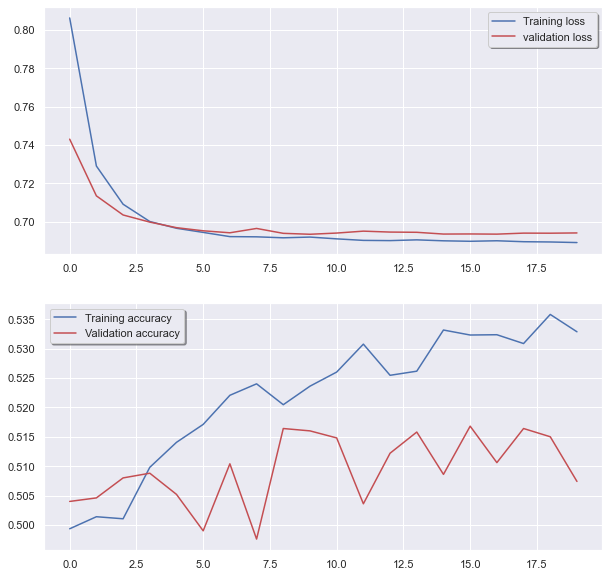

In [6]:
from keras.models import Model
target_model.trainable=False
layer_name = 'getter'
x = layers.Dense(10, activation="tanh")(target_model.get_layer(layer_name).output)
o=layers.Dense(1, activation="sigmoid")(x)
mollified_target_model= Model(inputs=target_model.input, outputs=[o])

see_X3=X3
see_X4=X4
bin_Y3=np.ones((len(see_X3),1))
bin_Y4=np.zeros((len(see_X4),1))
#vstack see_X3 and see_X4
see_X=np.vstack((see_X3,see_X4))
#vstack bin_Y3 and bin_Y4
bin2_Y=np.vstack((bin_Y3,bin_Y4))
#shuffle see_X and bin2_Y
see_X,bin2_Y=unison_shuffled_copies(see_X, bin2_Y)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mollified_target_model.compile(optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY),loss="binary_crossentropy",metrics=['acc'])
mollified_target_model.summary()
history_target_mol = mollified_target_model.fit(
    see_X, bin2_Y, batch_size=32, epochs=epochy,validation_split=0.2,verbose=0,callbacks=[callback]
)
#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].plot(history_target_mol.history['loss'], color='b', label="Training loss")
ax[0].plot(history_target_mol.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_target_mol.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_target_mol.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



bin2_Y_pred_mollified=mollified_target_model.predict(see_X)
#binarize bin2_Y_pred_mollified
bin2_Y_pred_mollified_star=np.copy(bin2_Y_pred_mollified)
bin2_Y_pred_mollified_star=np.where(bin2_Y_pred_mollified_star>0.55,1,0)


#calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:",round(accuracy_score(bin2_Y, bin2_Y_pred_mollified_star),10))
#calculate the precision
from sklearn.metrics import precision_score
print("Precision:",precision_score(bin2_Y, bin2_Y_pred_mollified_star))
#calculate the recall
from sklearn.metrics import recall_score
print("Recall:",recall_score(bin2_Y, bin2_Y_pred_mollified_star))
#calculate the f1 score
from sklearn.metrics import f1_score
print("F1 score:",f1_score(bin2_Y, bin2_Y_pred_mollified_star))